In [1]:
from models_v2 import *
from src.plots import *
import torch

NUM_REGISTERS = 4
MODEL_PATH = f"models/DeitSegModel_epoch50_reg{NUM_REGISTERS}_unfrozen1/best_checkpoint.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_PATH = "images/ADE_val_00001112.jpg"

In [2]:
print("Loading model: segmentation_deit_small_patch16_LS_reg")
# NOTE: we always used 224x224 images for deit so this has been set as default
model = segmentation_deit_small_patch16_LS_reg(
    num_registers=NUM_REGISTERS,
)

Loading model: segmentation_deit_small_patch16_LS_reg
>>>>>>>>>>>>>>>>>>>> PRETRAINED MODEL WILL BE USED
>>>>>>>>>>>>>>>>>>>> VIT PRETRAINED MODEL LOADED!
>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 4
Adding 4 register token(s) for fine-tuning.


In [3]:
model_dict = torch.load(MODEL_PATH, map_location=DEVICE)['model']
# model_dict.keys()

model.load_state_dict(model_dict)
model.eval()
print("Model loaded from", MODEL_PATH)

C:\Users\agata\AppData\Local\Temp\ipykernel_24112\1817814103.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(MODEL_PATH, map_location=DEVICE)['mo

Model loaded from models/DeitSegModel_epoch50_reg4_unfrozen1/best_checkpoint.pth


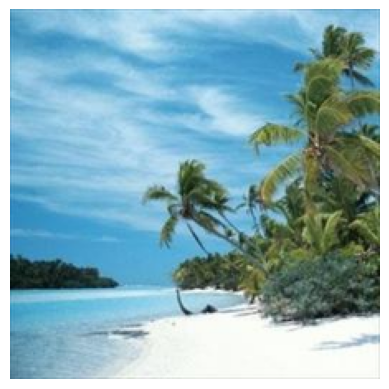

In [4]:
# Load image
image = Image.open(IMAGE_PATH).convert("RGB")
image = image.resize((224, 224))

image_np = np.array(image)
plt.imshow(image_np)
plt.axis("off")
plt.show()

In [5]:
from torchvision import transforms

#  image ToTensor, add batch size 1
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(DEVICE)
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [6]:
output = model(image_tensor)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function for data visualization
def visualize_image_mask(sample):
    plt.figure(figsize=(8, 4))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sample["image"].numpy().transpose(1, 2, 0))  # CHW → HWC

    # Show the mask
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.xticks([])
    plt.yticks([])
    
    mask = sample["mask"]
    if mask.ndim == 3 and mask.shape[0] == 1:
        # Case: (1, H, W)
        mask = mask.squeeze(0)
    elif mask.ndim == 3 and mask.shape[0] > 1:
        # Case: (C, H, W) semantic segmentation mask (e.g., one-hot)
        mask = mask.argmax(0)
    
    plt.imshow(mask)
    plt.show()


# Helper function for data visualization
def save_mask_only(sample, save_path="mask.png"):
    mask = sample["mask"]
    if mask.ndim == 3 and mask.shape[0] == 1:
        # Case: (1, H, W)
        mask = mask.squeeze(0)
    elif mask.ndim == 3 and mask.shape[0] > 1:
        # Case: (C, H, W) semantic segmentation mask (e.g., one-hot)
        mask = mask.argmax(0)
    
    # Save the mask image only
    plt.imshow(mask)
    plt.axis('off')  # Hide axes
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Mask saved at {save_path}")


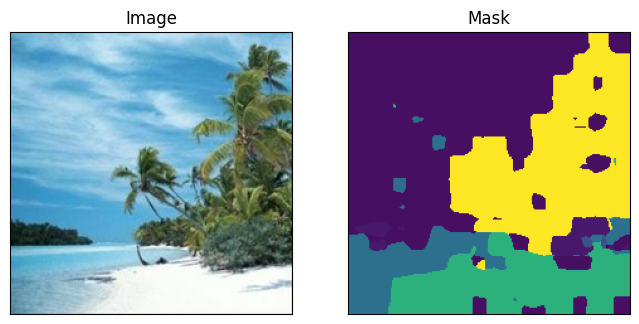

In [8]:
sample = {
    "image": image_tensor.squeeze(0).cpu(),  # remove batch size 1 dimension
    "mask": output.squeeze(0).detach().cpu(),
}

visualize_image_mask(sample)


In [9]:
save_mask_only(sample, save_path=f"images/DEIT_mask_{NUM_REGISTERS}.png")

Mask saved at images/DEIT_mask_4.png
